In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
# from tensorflow import set_random_seed
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

1st we removed the noise in excel by using low pass filter.

In [ ]:
df=pd.read_csv('/content/data1.csv')
df.head()

,X,Y,Y1
0,-39.20,6.22,6.220000
1,-39.20,-14.93,4.105000
2,-39.20,-24.20,1.274500
3,-38.79,19.60,3.107050
4,-36.73,-19.40,0.856345


In [ ]:
df.columns

Index(['X', 'Y', 'Y1'], dtype='object')

In [ ]:
df.isnull().sum()

X     0
Y     0
Y1    1
dtype: int64

In [ ]:
df=df.dropna()

In [ ]:
# df1 = df.sort_values("X", axis = 0, ascending = True)

In [ ]:
# df1 = df1.reset_index()

In [ ]:
df1=df.drop(columns=['X','Y'],axis=1)
df1.head()

,Y1
0,6.220000
1,4.105000
2,1.274500
3,3.107050
4,0.856345


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340018 entries, 0 to 340017
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Y1      340018 non-null  float64
dtypes: float64(1)
memory usage: 5.2 MB


In [ ]:
0.25*len(df1)

85004.5

In [ ]:
df1[0:85005]

,X,Y
0,-39.20,-14.93
1,-39.20,-24.20
2,-39.20,6.22
3,-38.79,19.60
4,-36.73,-19.40
...,...,...
85000,-0.45,-2.04
85001,-0.45,1.21
85002,-0.45,-2.58
85003,-0.45,-2.34


In [ ]:
train = df1[0:255014]
test = df1[255014:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (255014, 1)
Test dataset shape: (85004, 1)


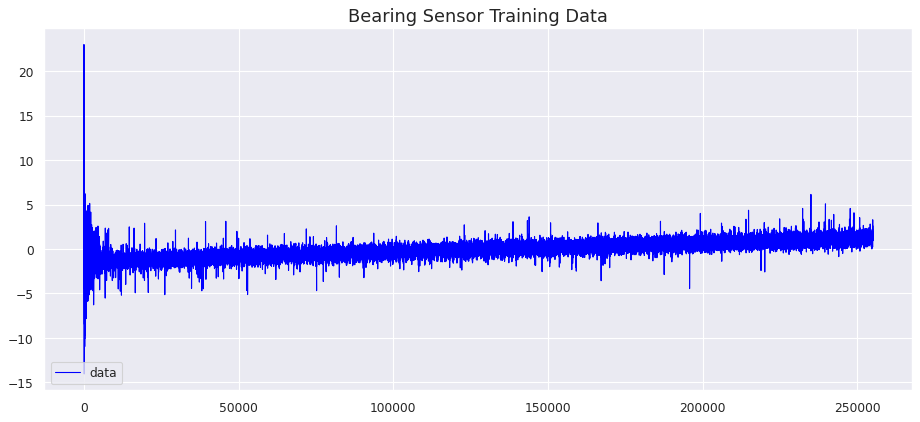

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Y1'], label='data', color='blue', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [ ]:
seed(10)

In [ ]:
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

In [ ]:
train_fft

array([[6.22      +0.j],
       [4.105     +0.j],
       [1.2745    +0.j],
       ...,
       [1.3805236 +0.j],
       [1.79947123+0.j],
       [1.63752411+0.j]])

In [ ]:
train_fft[:,0]

array([6.22      +0.j, 4.105     +0.j, 1.2745    +0.j, ...,
       1.3805236 +0.j, 1.79947123+0.j, 1.63752411+0.j])

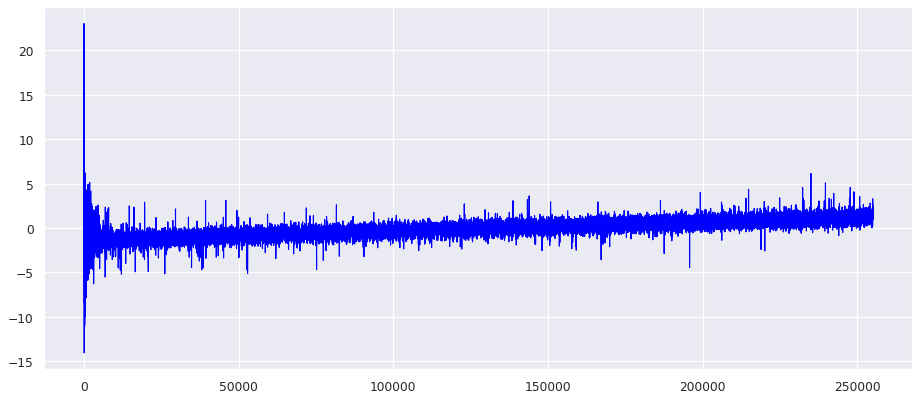

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)

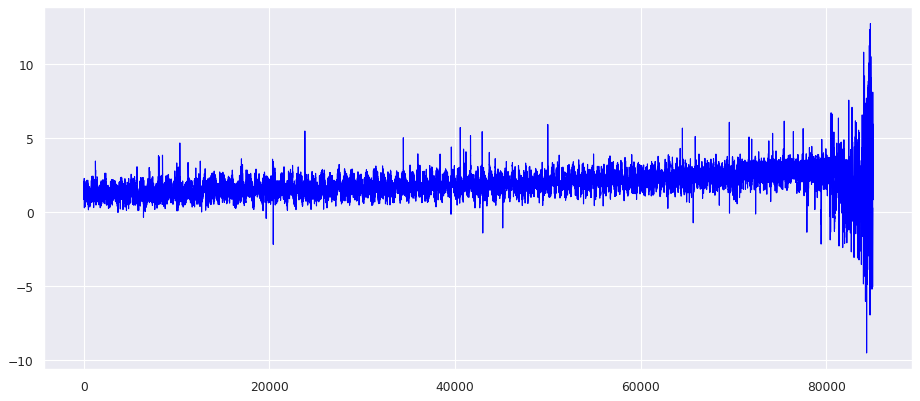

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)

In [ ]:
import joblib

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (255014, 1, 1)
Test data shape: (85004, 1, 1)


In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1152      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [ ]:
nb_epochs = 15
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/15
24227/24227 [==============================] - 134s 5ms/step - loss: 0.0039 - val_loss: 7.1442e-04
Epoch 2/15
24227/24227 [==============================] - 126s 5ms/step - loss: 7.6245e-04 - val_loss: 0.0014
Epoch 3/15
24227/24227 [==============================] - 124s 5ms/step - loss: 7.4901e-04 - val_loss: 0.0011
Epoch 4/15
24227/24227 [==============================] - 125s 5ms/step - loss: 7.5383e-04 - val_loss: 0.0012
Epoch 5/15
24227/24227 [==============================] - 125s 5ms/step - loss: 7.5474e-04 - val_loss: 5.9737e-04
Epoch 6/15
24227/24227 [==============================] - 125s 5ms/step - loss: 7.5000e-04 - val_loss: 7.4043e-04
Epoch 7/15
24227/24227 [==============================] - 126s 5ms/step - loss: 7.4485e-04 - val_loss: 4.7064e-04
Epoch 8/15
24227/24227 [==============================] - 125s 5ms/step - loss: 7.2472e-04 - val_loss: 5.3263e-04
Epoch 9/15
24227/24227 [==============================] - 124s 5ms/step - loss: 7.0476e-04 - val_loss: 1

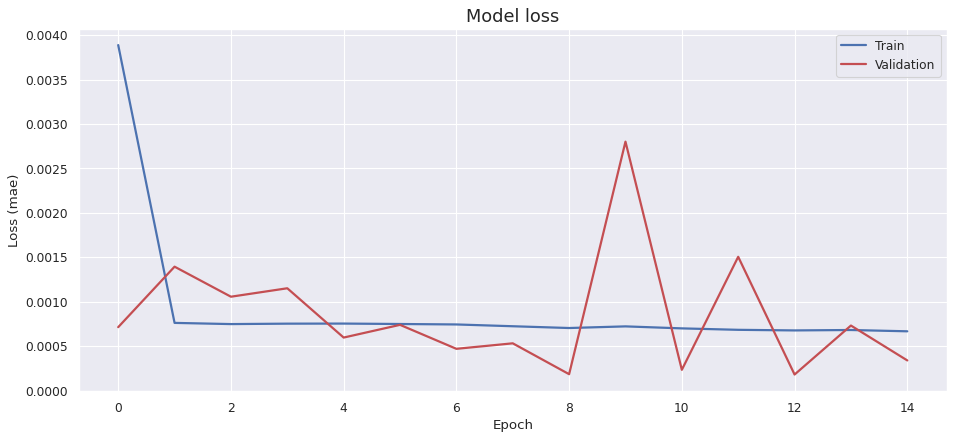

In [ ]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

7970/7970 [==============================] - 24s 3ms/step


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.1)

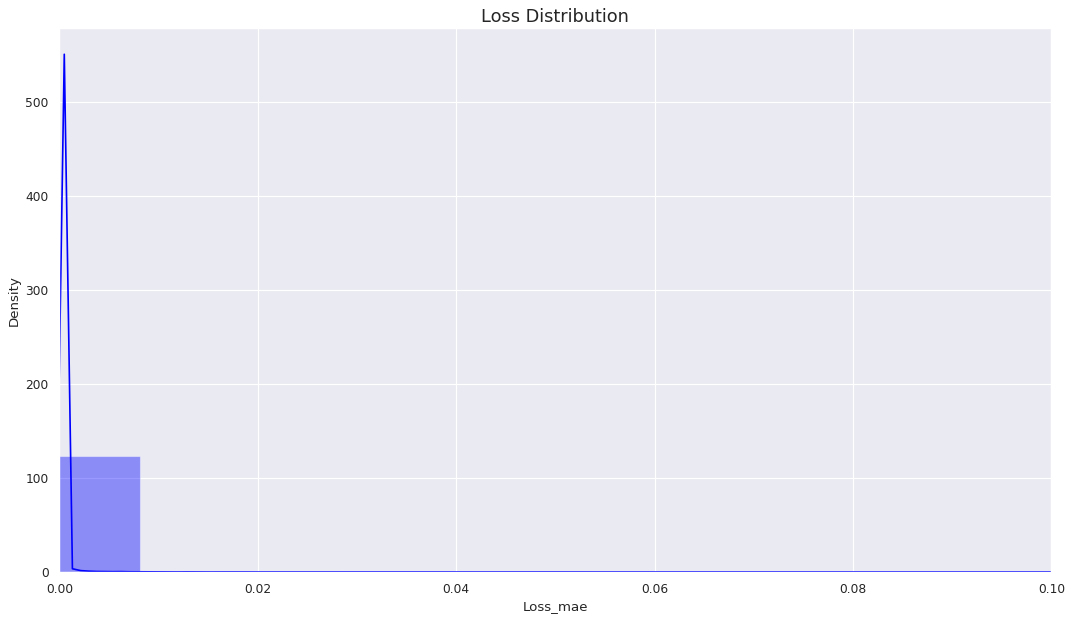

In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,0.1])

In [ ]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.01
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

2657/2657 [==============================] - 7s 3ms/step


,Loss_mae,Threshold,Anomaly
255014,0.000419,0.01,False
255015,0.000383,0.01,False
255016,0.000359,0.01,False
255017,0.000256,0.01,False
255018,0.000331,0.01,False


In [ ]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.05
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

7970/7970 [==============================] - 24s 3ms/step


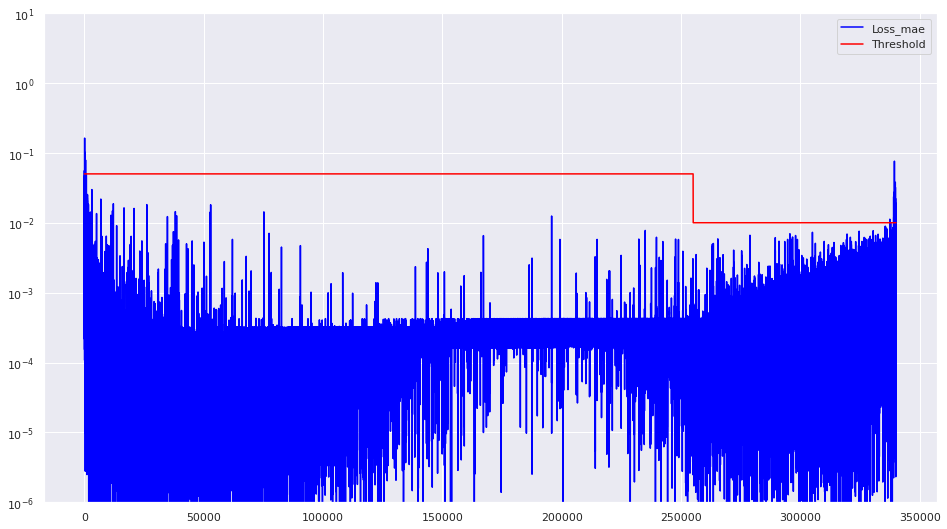

In [ ]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-6,1e1], color=['blue','red'])